# CITS5508 Lab 4 Project 2: Random Forest Regression on Abalone Ring Count

Name: Joey Koh<br>
Student number: 21506379  
Date created: 23 April 2020  
Last modified: 2 May 2020  

This notebook compares the performance of a Random Forest regressor with and without dimensionality reduction. It is addressing a regression task on predicting abalone ring count using various attribute inputs.<br>

Database Citation:
Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

Below is the attribute information.

    Name		Data Type	Meas.	Description
	----		---------	-----	-----------
	Sex		nominal			M, F, and I (infant)
	Length		continuous	mm	Longest shell measurement
	Diameter	continuous	mm	perpendicular to length
	Height		continuous	mm	with meat in shell
	Whole weight	continuous	grams	whole abalone
	Shucked weight	continuous	grams	weight of meat
	Viscera weight	continuous	grams	gut weight (after bleeding)
	Shell weight	continuous	grams	after being dried
	Rings		integer			+1.5 gives the age in years

## 1. Setup, Data Cleaning, Visualisations

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
#Use jupyter's backend to render plots
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns; sns.set(color_codes= True)
#from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import warnings
#warnings.filterwarnings("ignore") #clear warnings

#Prepare the data, give headings from data information
raw_data = pd.read_csv("abalone.data",
                      header=None,
                      names=['sex','length','diameter','height','whole weight','shucked weight','viscera weight','shell weight','rings']
                      )

#Quick check for missing values and data size
print("Are there any missing values?", raw_data.isnull().values.any())
print("Dimensions:", raw_data.shape)

#View first few lines and inspect columns
raw_data.head()


Are there any missing values? False
Dimensions: (4177, 9)


,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


**The 'sex' feature is text-based categorical data, we need to handle it.** No missing values to handle. We note the 4177 instances by 9 attributes dimension size.

### 1.1 Handling Categorical Text Feature

In [2]:
data = raw_data #make a copy
#Define encoder
enc = OneHotEncoder(handle_unknown='ignore')

#Get array of transformed categories
s_trans = enc.fit_transform(data['sex'].values.reshape(-1,1)).toarray() 

#Check order of categories for headings
print(enc.categories_)
s_onehot = pd.DataFrame(s_trans, columns= ['sex F','sex I','sex M'])

#Concatenate new one-hot encoded columns and remove predecessor column
data_enc = pd.concat([s_onehot,data], axis=1)
data_enc = data_enc.drop('sex', axis=1)

#Check first few rows
data_enc.head()

[array(['F', 'I', 'M'], dtype=object)]


,sex F,sex I,sex M,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,0.0,0.0,1.0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,0.0,0.0,1.0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,1.0,0.0,0.0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,0.0,0.0,1.0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,0.0,1.0,0.0,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


New data looks good, all numerical values now.

### 1.2 Visualisations

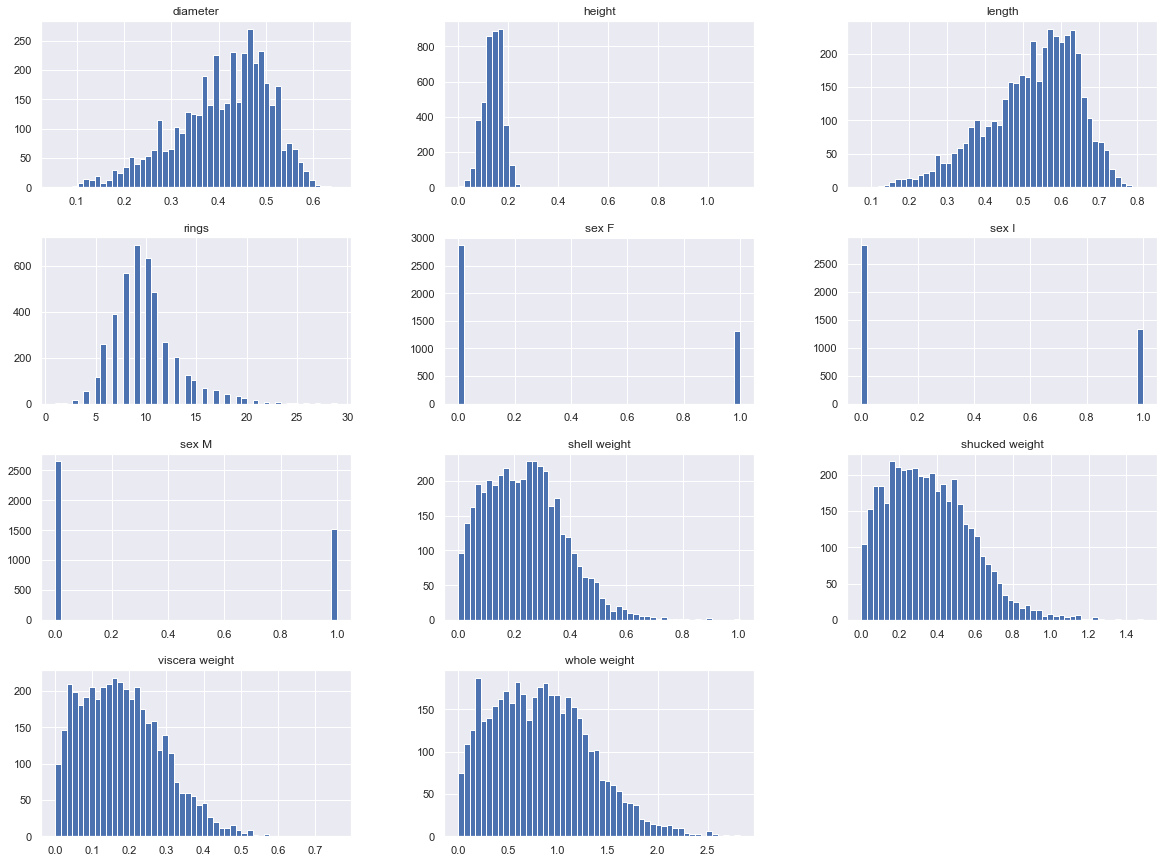

In [3]:
#Get visualisations
data_enc.hist(bins=50, figsize=(20,15))
plt.show()

These are the graphs showing the distribution for each attribute.<br>
**Observations:**
- We **should not remove low label instances** for 'rings' as the small sample size still provides a signal in the data. This is not a classfication problem.
- As all distributions are normally distributed (except for the encoded categories), a StandardScalar is suitable for use if feature scaling is required.
- The distribution in 'sex' between M, F, I are roughly balanced.
- The labels attribute 'rings' appears to be right skewed, i.e. mean is right of median.

### Visualising Relationship between each feature and quality

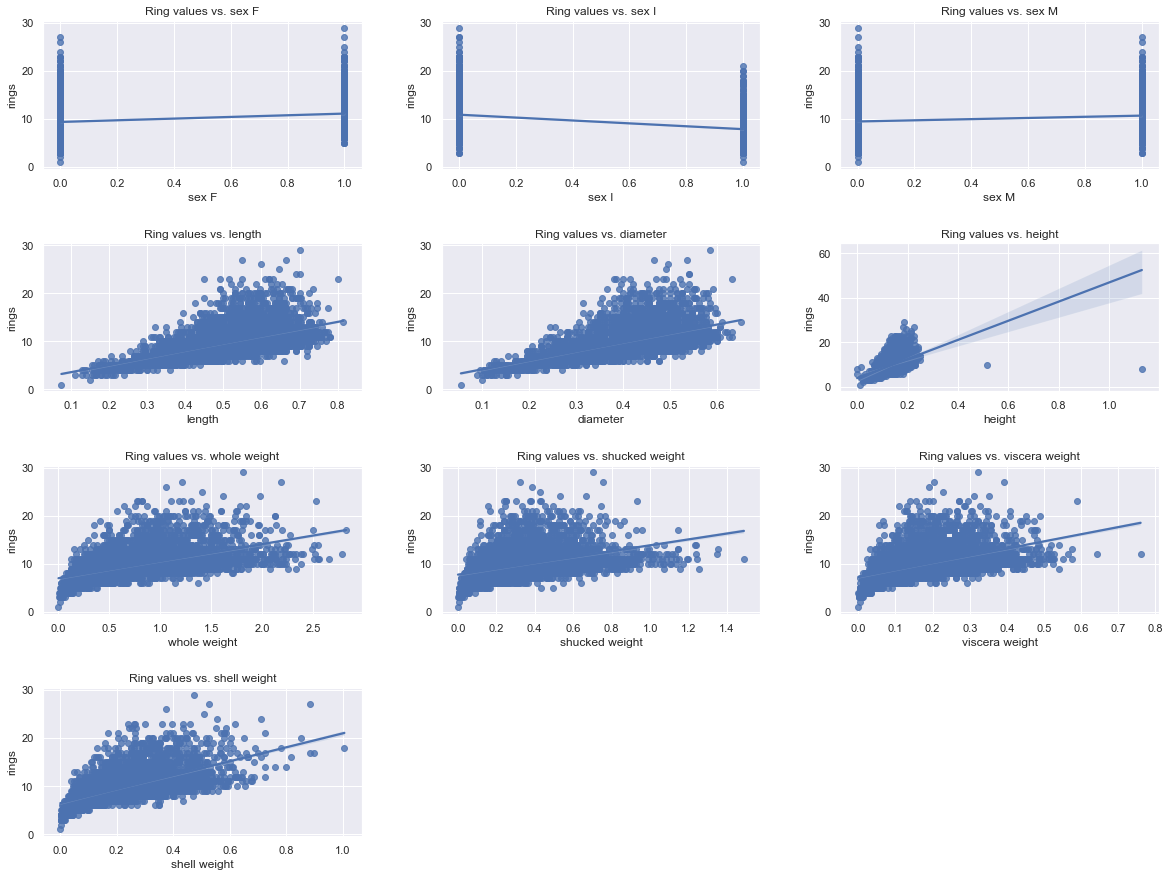

In [4]:
#Plotting each feature against Ring Values
feat = ['sex F', 'sex I', 'sex M',
        'length', 'diameter','height', 'whole weight',
        'shucked weight' ,'viscera weight' ,'shell weight',
       ]

#Creating figures 
fig = plt.figure(figsize=(20,15))
fig.subplots_adjust(hspace = 0.5, wspace=0.25) #space between plots

#loop to create plots
for i in range(len(feat)): #repeat for every feat
    f = fig.add_subplot(4,3,i+1)
    ax = sns.regplot(x = data_enc[feat[i]], y = data_enc['rings']) #regplot to create scatter plot with line of best fit
    plt.title('Ring values vs. ' + feat[i])
    

**Observations**<br>
Apart from ring count vs. 'sex' graphs:
- There seems to be a visible positive correlation for ring counts vs. other features. This intuitively makes sense with length, diameter, height, whole weight and shell weight. I.e. the number of rings increases with a general mass and size increase.
- The instances start intially heavily clustered at the low end of the feature's value, but quickly scatters as the feature's value increases. From this, it is likely to be harder to predict the instances in the lower range of ring count correctly, compared to the higher ring count ranges. As the instances are more scattered and distinct.

Overall: We note some form of relationship between each feature and the ring count, thus we need use multiple features to capture the full pattern.

## 2. Data Split

In [5]:
#Separate labels and features
y= data_enc['rings']
X= data_enc.drop('rings',axis=1)
#split dataset at 85/15 ratio
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size= 0.15, random_state= 0)


**Feature scaling is not required for the Random Forest Regressor** as it is decision tree based. Tree based models are constucted in a greedy manner, by choosing the best split points to minimise the loss function. Thus, the relative scales of different features do not matter.

## 3. Random Forest Regressor
Decision Tree based on splitting within a random subset of features

In [6]:
#functions used
def getPredictionAndErrors(model, features_X, labels_y): #returns rounded predictions, MSE and raw errors
    pred = model.predict(features_X) #get prediction values
    pred_round = pred.round() #round predictions
    pred_round = pred_round.astype("int64") #change to integers
    raw_errors = pred_round - labels_y #compute raw prediction errors
    mse = mean_squared_error(labels_y,pred_round).round(2) #compute MSE
    return pred_round, mse, raw_errors

def displayRawErrors(raw_errors1,label1,raw_errors2,label2,title): #plots raw error histograms
    raw_errors1.hist(label=label1, bins=15, align= "mid")
    raw_errors2.hist(label=label2, bins=15, align="mid")
    plt.legend(loc='best')
    plt.title(title)
    plt.ylabel("Count")
    plt.xlabel("Raw Error of Quality")
    plt.show()

def displayRawErrors2(raw_errors,title): #plots single raw error histogram
    raw_errors.hist(bins=20, align= "mid")
    plt.title(title)
    plt.ylabel("Count")
    plt.xlabel("Raw Error of Quality")
    plt.show()

### Hyperparameters Tuned
**Limiting the following helps prevent overfitting**
- n_estimators: Number of trees in the forest. The more learners in the ensemble, the greater the fitting to the training set.
- max_depth: Depth of each tree in the ensemble. The deeper the tree, the more the training set pattern is captured.
- max_leaf_nodes: Max number of final leaf nodes in the best-first order. As we want an ensemble of uncorrelated weak learners, we limit this to prevent strong correlated leaners from forming.

**Setting a base threshold for the following helps to ensure some signal is captured, while noise is ignored.**
- min_samples_split: Minimum number of samples required to split an internal node.
- min_samples_leaf: Minimum number of samples required to be at a leaf node, the base of the tree.

As a gridsearch took too long, manual tuning was conducted and decent hyperparameters were as follows.

In [7]:
#Prepare regressor with tuned hyperparameters
rfor_reg = RandomForestRegressor(n_estimators=200,
                                 max_depth= 8,
                                 max_leaf_nodes=40,
                                 min_samples_split=5,
                                 min_samples_leaf=10,
                                 n_jobs=-1, #use all cores
                                 random_state=0)

rfor_reg.fit(train_X,train_y); #fit on training set

### 3.1 MSE, Rounded Predictions and Raw Errors

Model trained with full dataset: Predicting on test set, raw error counts:
  1     164
 0     163
-1      83
 2      66
-2      54
-3      22
 3      21
-4      17
 4      10
-5       8
-6       6
 5       4
-8       3
-9       3
-7       1
-10      1
 6       1
Name: rings, dtype: int64
Model trained with full dataset: Predicting on training set, raw error counts:
  0     974
 1     928
-1     508
 2     413
-2     213
-3     131
 3     127
-4      91
-5      46
 4      31
-6      28
-7      23
-8      13
 5       8
-9       7
-10      3
 6       2
 7       2
 8       1
-15      1
Name: rings, dtype: int64


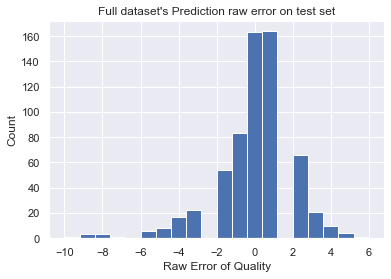

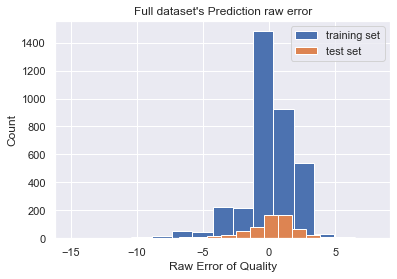

The MSE on the training and test set respectively are:
  3.9 ,  4.28


In [8]:
#Get rounded predictions, MSE and raw errors on test and training sets
test_pred, test_mse, test_raw_error = getPredictionAndErrors(rfor_reg, test_X, test_y)
train_pred, train_mse, train_raw_error = getPredictionAndErrors(rfor_reg, train_X, train_y)
print("Model trained with full dataset: Predicting on test set, raw error counts:\n", test_raw_error.value_counts())
print("Model trained with full dataset: Predicting on training set, raw error counts:\n", train_raw_error.value_counts())

#Call display raw errors function
displayRawErrors2(test_raw_error,"Full dataset's Prediction raw error on test set")
displayRawErrors(train_raw_error,"training set",test_raw_error,"test set", "Full dataset's Prediction raw error")

print("The MSE on the training and test set respectively are:\n ", train_mse,', ',test_mse)


**Observations:**<br>
- Based of the MSE, the model performs worse on the test set as expected from trying to generalise on unseen data. With a MSE of 4.28 compared to training set's 3.9. 

**On the histogram:**
- There is a similar normal distribution in raw prediction errors for both sets, with a prominent peak around 0 meaning that most of the predictions are either correct or have a raw error of +/- 2 rings. The model on the whole is able to predict the ring counts of instances well.
- Both also have left skew, with a tail in the left. This implies that the model tends to make some large underestimates of ring count for some instances. Note from the earlier visualiation of ring count distribution, that most of the instances are in the lower range. Thus, there are **less instances in the higher range for the model to learn the pattern of.** It is more likely to fail at predicting the correct ring count for these instances and instead generalise a lower ring count for them. **This would lead to underestimations for the instances with higher ring counts.**<br><br>

- A closer look at the raw error counts reveals that while the previous statement holds, the number of predicted instances with raw error= +1 is very similar to the number of correctly predicted instances(raw error=0) for both training and test sets. Ignoring the wide range but relatively few instances of underestimation, the model overall appears to favour slightly overestimating by 1 or 2 rings then underestimating by the same amount.
- Finally, we note that the number of correctly predicted instances for training and test sets are **974 and 163** respectively.

### 3.2 Feature Importance

In [9]:
#Obtain feature importances from random forest
feat,imp = [],[]
for name, score in zip(data_enc.columns, rfor_reg.feature_importances_.round(4)):
    feat.append(name)
    imp.append(score)

#find out what features contribute to the 95% importance threshold
sorted_imp= np.sort(imp)[::-1]#sort in reverse order high to low
sorted_imp_index= np.argsort(imp)[::-1] #get index of reverse sort

cs = np.cumsum(sorted_imp) #np array of cumulative sums
cs_index = np.argwhere(cs>0.95) #get index of cumulative sums >0.95
reduce_dim_by = len(cs_index)-1 #dimensions to reduce by
keep_index = sorted_imp_index[:-reduce_dim_by] #keep features's orignal index

keep_feat = np.array(feat)[keep_index] #array of features to keep
print("We reduce the dimensions to the following features: \n",keep_feat)


We reduce the dimensions to the following features: 
 ['shell weight' 'shucked weight' 'whole weight' 'sex I' 'diameter']


## 4. Reduced Dimensions Random Forest Regressor

From previous section, the feature importances that contribute to the 95% threshold are 'shell weight', 'shucked weight', 'whole weight', 'sex I' and 'diameter'<br>

As the 'sex I' feature was produced from one-hot encoding, we can keep it after encoding.<br>
Let's drop all features besides these.

In [10]:
#Reduce feature columns as stated
test_X_new = test_X[['shell weight', 'shucked weight', 'whole weight', 'sex I','diameter']]
train_X_new = train_X[['shell weight', 'shucked weight', 'whole weight', 'sex I','diameter']]

#view lines from reduced dimensions feature set
train_X_new.head()


,shell weight,shucked weight,whole weight,sex I,diameter
598,0.360,0.369,1.0540,1.0,0.495
3217,0.125,0.149,0.3880,0.0,0.340
3287,0.205,0.305,0.7085,0.0,0.460
615,0.148,0.128,0.3865,0.0,0.345
227,0.070,0.078,0.2050,1.0,0.270


The dimensions are now reduced. Now we can train on this reduced data set.

### 4.1 New MSE, Rounded Predictions and Raw Errors

Model trained with reduced dataset: Predicting on test set, raw error counts:
  0     169
 1     161
-1      80
 2      62
-2      52
-3      24
 3      24
-4      15
 4      11
-5      10
-6       6
-8       4
 5       3
-9       2
 6       1
-10      1
-7       1
 7       1
Name: rings, dtype: int64
Model trained with reduced dataset: Predicting on training set, raw error counts:
  0     982
 1     938
-1     485
 2     408
-2     208
-3     142
 3     130
-4      80
-5      46
 4      35
-6      33
-7      21
-8      14
 5      10
-9       6
-10      5
 6       3
 8       2
 7       1
-15      1
Name: rings, dtype: int64


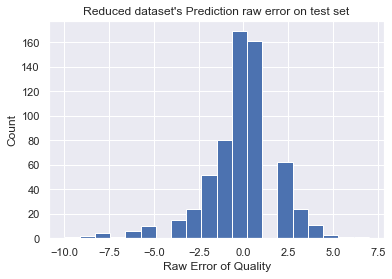

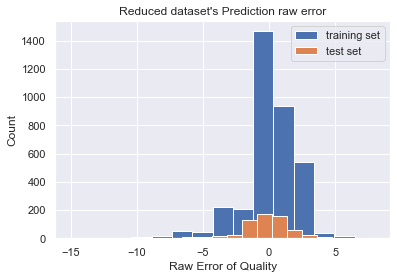

The MSE on the training and test set respectively are:
  4.0 ,  4.37


In [11]:
#Fit previous model on new training set
rfor_reg.fit(train_X_new,train_y); #fit on new training set

#Get rounded predictions, MSE, raw errors for test and training sets
test_pred_new, test_mse_new, test_raw_error_new = getPredictionAndErrors(rfor_reg, test_X_new, test_y)
train_pred_new, train_mse_new, train_raw_error_new = getPredictionAndErrors(rfor_reg, train_X_new, train_y)
print("Model trained with reduced dataset: Predicting on test set, raw error counts:\n", test_raw_error_new.value_counts())
print("Model trained with reduced dataset: Predicting on training set, raw error counts:\n", train_raw_error_new.value_counts())

#Call display raw errors function
displayRawErrors2(test_raw_error_new,"Reduced dataset's Prediction raw error on test set")
displayRawErrors(train_raw_error_new,"training set",test_raw_error_new,"test set", "Reduced dataset's Prediction raw error")
print("The MSE on the training and test set respectively are:\n ", train_mse_new, ', ',test_mse_new)


**Observations:**<br>
- Based of the MSE, the model performs worse on the test set as expected from trying to generalise on unseen data. With a MSE of 4.37 compared to training set's 4.0.

**On the histogram:**
- There is a similar normal distribution in raw prediction errors for both sets, with a prominent peak around 0 meaning that most of the predictions are either correct or have a raw error of +/- 2 rings. The model on the whole is **still** able to predict the ring counts of instances well.

- Both also have left skew, with a tail in the left. This implies that the model tends to make some large underestimates of ring count for some instances. Note from the earlier visualiation of ring count distribution, that most of the instances are in the lower range. Thus, there are **less instances in the higher range for the model to learn the pattern of.** It is more likely to fail at predicting the correct ring count for these instances and instead generalise a lower ring count for them. **This would lead to underestimations for the instances with higher ring counts.**<br><br>

- A closer look at the raw error counts reveals that while the previous statement holds, the number of predicted instances with raw error= +1 is very similar to the number of correctly predicted instances(raw error=0) for both training and test sets. Ignoring the wide range but relatively few instances of underestimation, the model overall appears to favour slightly overestimating by 1 or 2 rings then underestimating by the same amount.
- Finally, we note that the number of correctly predicted instances for training and test sets are **982 and 169** respectively.

## 5. Conclusion

**Comparing the Performances**<br>

**Overall the similarities of the Random Forest regressor trained with the full and reduced dataset are:**

- Similarities in raw error distribution. See previous observations and explanations for more info.
- Both have their MSE for the test set lower than for their training set. As the model fails to generalise equally as well on data unseen.
- Both appear to generally have a slight small overestimation in ring counts.

**Differences:**
- Firstly, remind ourselves that the MSE of the model trained with the full dataset was **3.9 and 4.28** on the training and test set respectively. Comparing with the new model with the same hyperparameters trained on the reduced dataset, we now have a MSE of **4.0 and 4.37** on the training and test set respectively. Both MSEs have slightly increased from before. 
- As expected, we are trading a slightly higher bias for reduced training time as some information is lost from the dimensionality reduction. However, less information to process results in faster training time.
- Based on the dimensionality reduction threshold we set as 95%, we gave up 5% of feature importance to achieve faster training time.
- Just comparing the number of correctly predicted ring count instances, on the training set and test set respectively we have **974 and 163** for the full dataset model, and **982 and 169** for the reduced dataset model.
- This slight improvement by reducing the dimensions could potentially be due to the link between removing redundant features with removing noise in the dataset. Thus, the signal of the dataset is captured better and the model performance improves in that regard. However, this is only comparing the single statistic and not the overall errors.
<br><br>
**In conclusion, we kept to a Random Forest regressor model with tuned hyperparameters. We experimented using the full dataset and using a 95% feature importance threshold for feature selection. 5% of feature importance was sacrificed, resulting in a slightly higher bias and MSE. Yet the training speed of the reduced dimensionality model and raw nuber of correct predictions increased.**